In [22]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import time

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [23]:
df = pd.read_csv("data/24h_candle.csv", delimiter=',', index_col=0)
df.head()

,id,date_time,open,close,low,high,volume,pair_id
#,,,,,,,,
1,10362847,2015-08-01 07:00:00.000000,284.000000,279.845023,275.724508,284.000000,301.376392,83
2,10362848,2015-08-02 07:00:00.000000,280.000000,286.438075,280.000000,286.438075,106.563859,83
3,10362849,2015-08-03 07:00:00.000000,285.438300,288.965644,284.286275,288.965644,75.706794,83
4,10362850,2015-08-04 07:00:00.000000,281.104486,288.000000,281.104486,288.000000,11.947218,83
5,10362851,2015-08-05 07:00:00.000000,288.200000,287.569800,279.793314,288.965425,9.297527,83


In [25]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

all_df = df.copy()
all_df.drop(['id'], axis=1, inplace=True)

x = all_df[['open', 'low', 'high', 'volume']].copy()
y = all_df['close'].copy()

x[['open', 'low', 'high', 'volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [26]:
x.head()

,open,low,high,volume
#,,,,
1,0.033761,0.038765,0.023217,2.790273e-06
2,0.032304,0.040403,0.024101,9.291998e-07
3,0.034284,0.042046,0.025018,6.344176e-07
4,0.032706,0.040827,0.024668,2.531289e-08
5,0.035290,0.040324,0.025018,0.000000e+00


In [27]:
def load_data(X, seq_len, train_size=0.9):
    
    amount_of_features = X.shape[1] 
    X_mat = X.as_matrix() 
    
    sequence_length = seq_len + 1 
    data = []
    

    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[train_split:, :-1] 
    y_test = data[train_split:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

In [28]:
X_mat = x.as_matrix()
len(X_mat)

713

In [29]:
window = 22
x['close'] = y
X_train, y_train, X_test, y_test = load_data(x, window)


In [30]:
def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

In [31]:
model = build_model(input_shape=(window, 5))

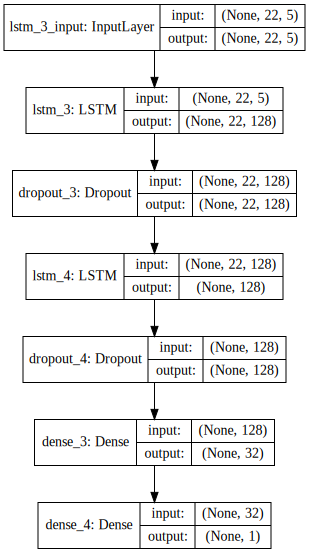

In [32]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [43]:
print('START FIT MODEL...')

model.fit(X_train, y_train, batch_size=32, epochs=500,
          verbose=0)

START FIT MODEL...


In [44]:
save_model(model, "model_btc_toTrainTest.h5")

In [ ]:
#save_model(model, "model_btc_future22day_from1307.h5")

In [33]:
model = load_model("model_btc_future22day_from1307.h5")

In [46]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [47]:
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

In [48]:
trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 20.43 RMSE
Test Score: 652.20 RMSE


In [49]:
prices = all_df.close.values.astype('float32')
prices = prices.reshape(len(prices), 1)

In [38]:
all_df.head()

,date_time,open,close,low,high,volume,pair_id
#,,,,,,,
1,2015-08-01 07:00:00.000000,284.000000,279.845023,275.724508,284.000000,301.376392,83
2,2015-08-02 07:00:00.000000,280.000000,286.438075,280.000000,286.438075,106.563859,83
3,2015-08-03 07:00:00.000000,285.438300,288.965644,284.286275,288.965644,75.706794,83
4,2015-08-04 07:00:00.000000,281.104486,288.000000,281.104486,288.000000,11.947218,83
5,2015-08-05 07:00:00.000000,288.200000,287.569800,279.793314,288.965425,9.297527,83


In [50]:
trainPredictPlot = np.empty_like(prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

testPredictPlot = np.empty_like(prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(prices) - testPredict.shape[0]):len(prices), :] = testPredict

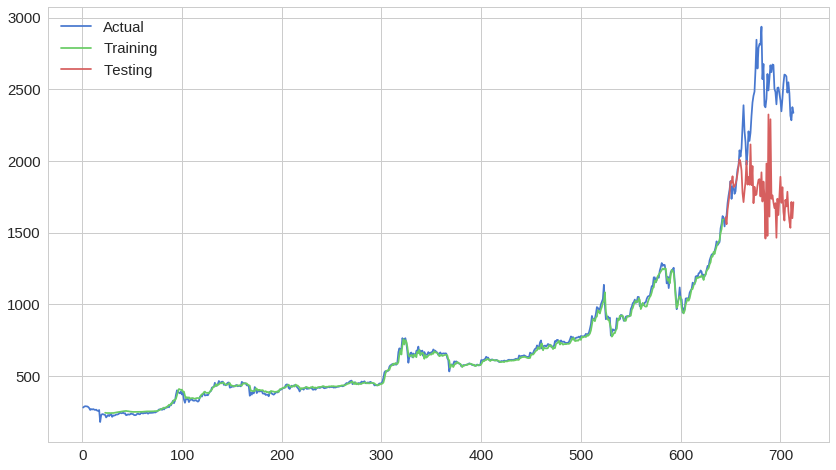

In [51]:
plt.plot(pd.DataFrame(prices, columns=["close"], index=all_df.index).close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=all_df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()

In [52]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

Actual = pd.DataFrame(prices, columns=["close"], index=all_df.index).close
Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.index).close
Testing = pd.DataFrame(testPredictPlot, columns=["close"], index=all_df.index).close

ActualValues = go.Scatter( x = np.arange(Actual.shape[0]), y = Actual, name = 'ActualValues')
TrainingValues = go.Scatter( x = np.arange(Training.shape[0]), y = Training, name = 'TrainingValues')
TestingValues = go.Scatter( x = np.arange(Testing.shape[0]), y = Testing, name = 'PredictedValues')

iplot([ActualValues,TrainingValues, TestingValues])